# Group Proposal

#### **Authors:** Linda Huang, Manav Kakar, Omer Tahir, Yuchen Zhang
#### **Group:** 2

## Introduction

1. **Relevant background information** on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal.

2. **Clearly state the question** you will try to answer with your project. Your question should involve one random variable of interest (the response) and one or more explanatory variables. Of the response variable, explain whether your project is focused on prediction, inference, or both.

3. **Identify and describe the dataset** that will be used to answer the question. Remember, this dataset is allowed to contain more variables than you need, in fact, exploring how the different variables in the dataset affect your model, is a crucial part of the project.

4. Also, be sure to **frame your question/objectives in terms of what is already known in the literature**. Be sure to include at least **two scientific publications** that can help frame your study (you will need to include these in the References section).

## Preliminary Results

In [48]:
library(tidyverse)
library(ggcorrplot)
# library(ggplot2)
# library(dplyr)
# library(GGally)
# library(gridExtra)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

In [2]:
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"

bike_data <- 
    read.csv(url, encoding = 'utf-8') |>
    setNames(c("date",
               "bike_count",
               "hour",
               "temperature",
               "humidity",
               "wind_speed",
               "visibility",
               "dew_point_temp",
               "radiation",
               "rain",
               "snow",
               "season",
               "holiday",
               "functional_day")) |>
    filter(functional_day == "Yes") |>
    select(-functional_day) 

In [3]:
View(head(bike_data))

,date,bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temp,radiation,rain,snow,season,holiday
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday
2,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday
3,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday
4,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday
5,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday
6,01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday


### Correlation plot

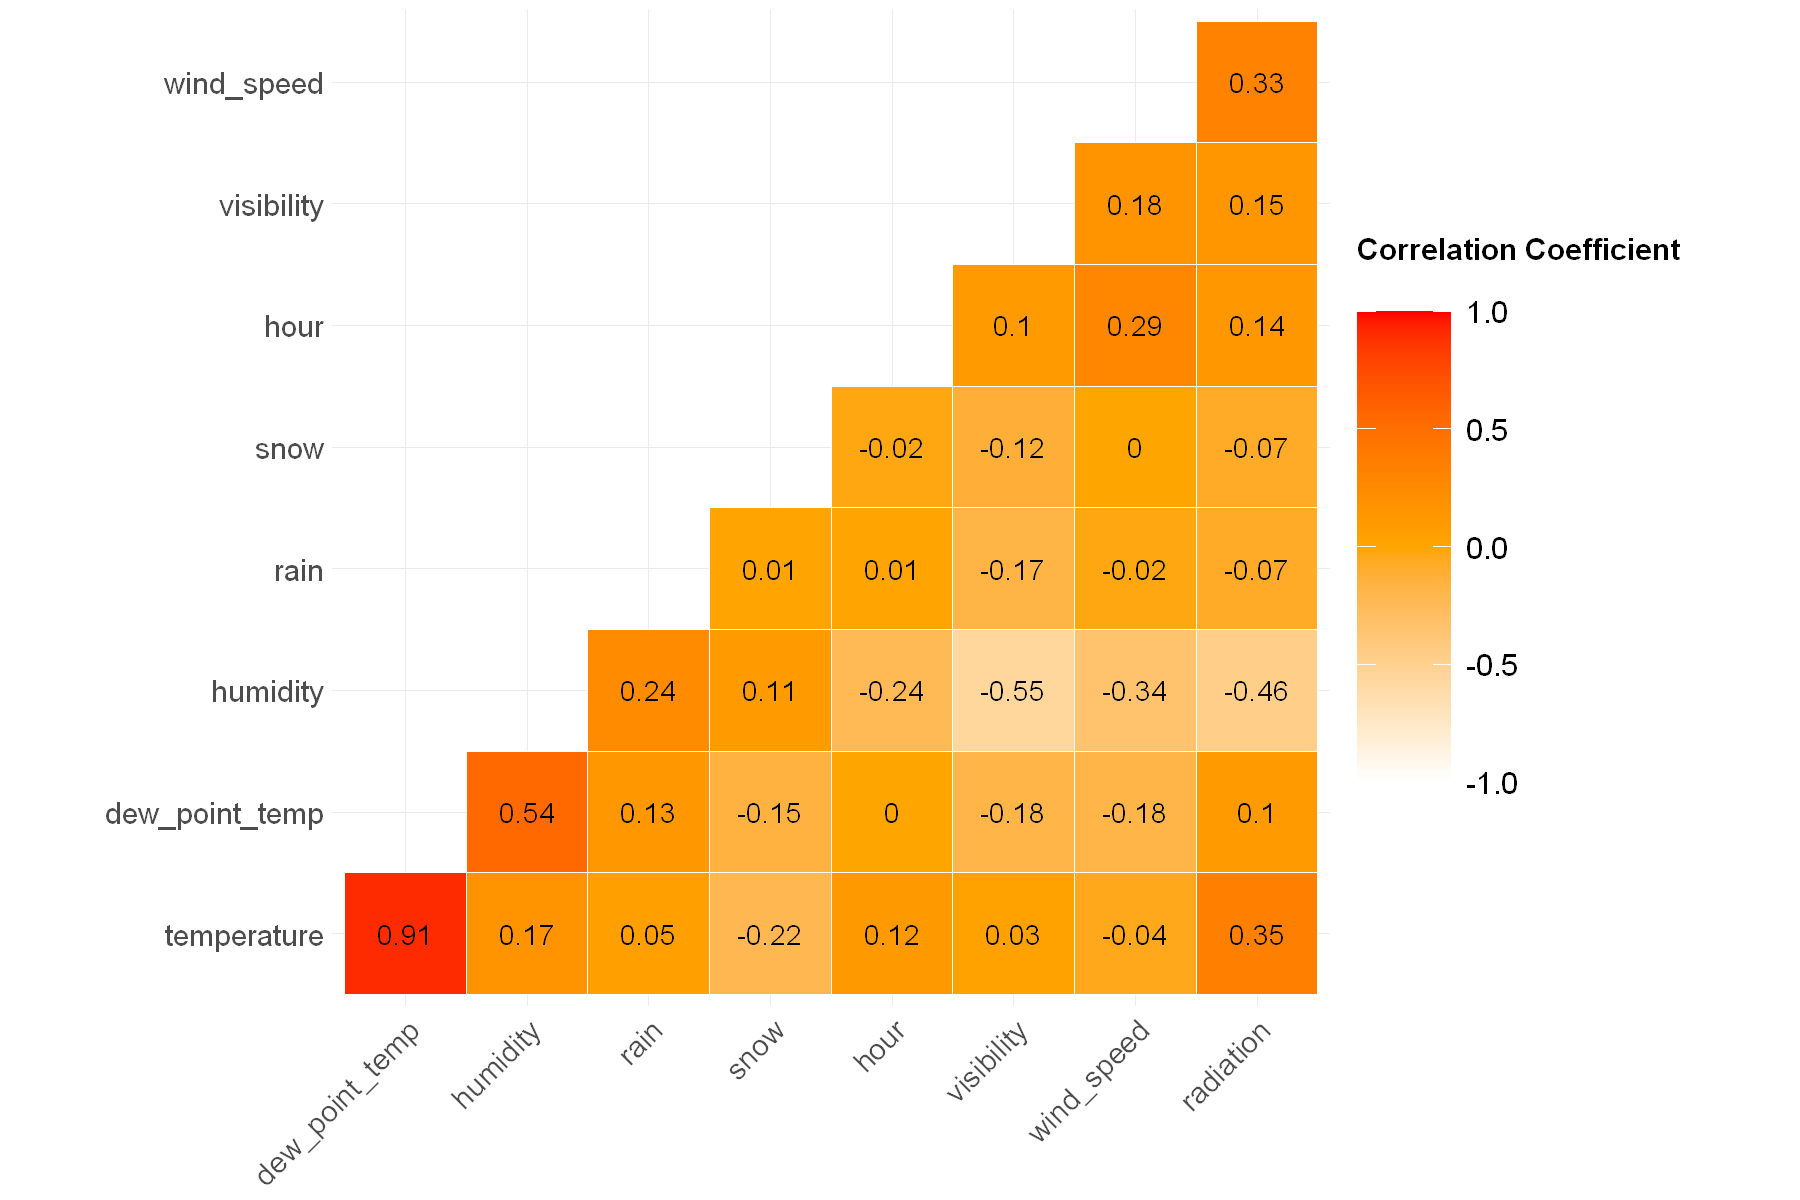

In [42]:
options(repr.plot.width = 15, repr.plot.height = 10)

corr_plot <- 
    bike_data |>
    select(-c(date, season, holiday, bike_count)) |>
    cor() |>
    round(2) |> 
    ggcorrplot(hc.order = TRUE,
               outline.col = "white",
               type = "lower",
               lab = TRUE,
               lab_size = 6,
               tl.cex = 18,
               colors = c("white", "orange", "red"),
               legend.title = "Correlation Coefficient\n") +
    theme(legend.title = element_text(size = 18, face = "bold"),
          legend.text = element_text(size = 18),
          legend.key.size = unit(2, "cm")) 

corr_plot

In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity.

From the correlation plot we can see there are some potential confounders, for example, temperature and dew_point_temp, visibility, dew_point_temp, radiation and humidity. 

In [73]:
VIF_MLR_bike <- 
    bike_data %>%
    select(-c(date, season, holiday)) %>%
    lm(bike_count ~ ., data = .) %>%
    vif() %>%
    round(3)

VIF_MLR_bike

hour    temperature       humidity     wind_speed     visibility 
         1.180         87.644         20.163          1.274          1.575 
dew_point_temp      radiation           rain           snow 
       116.462          2.011          1.084          1.096

James et al. (2013) in [*An Introduction to Statistical Learning*](https://www.statlearning.com/) (see Section 3.3.3 in Subsection Collinearity) indicate that, as a rule of thumb, a VIF value that exceeds 5 or 10 is an indicator of a  multicollinearity problem. 

In [74]:
VIF_MLR_bike <- 
    bike_data %>%
    select(-c(date, season, holiday, dew_point_temp)) %>%
    lm(bike_count ~ ., data = .) %>%
    vif() %>%
    round(3)

VIF_MLR_bike

hour temperature    humidity  wind_speed  visibility   radiation 
      1.178       1.629       2.533       1.272       1.564       1.911 
       rain        snow 
      1.071       1.091

#### Relation b/w high correlated variables and response variable

In [27]:
bike_data_1 <- bike_data %>%
              select(- date)%>%
              group_by(hour) %>%
              summarise(mean_bike_count= mean(bike_count))
bike_data_1


hour,mean_bike_count
<int>,<dbl>
0,561.4574
1,441.9233
2,312.7699
⋮,⋮
21,1066.5127
22,954.1671
23,693.9405


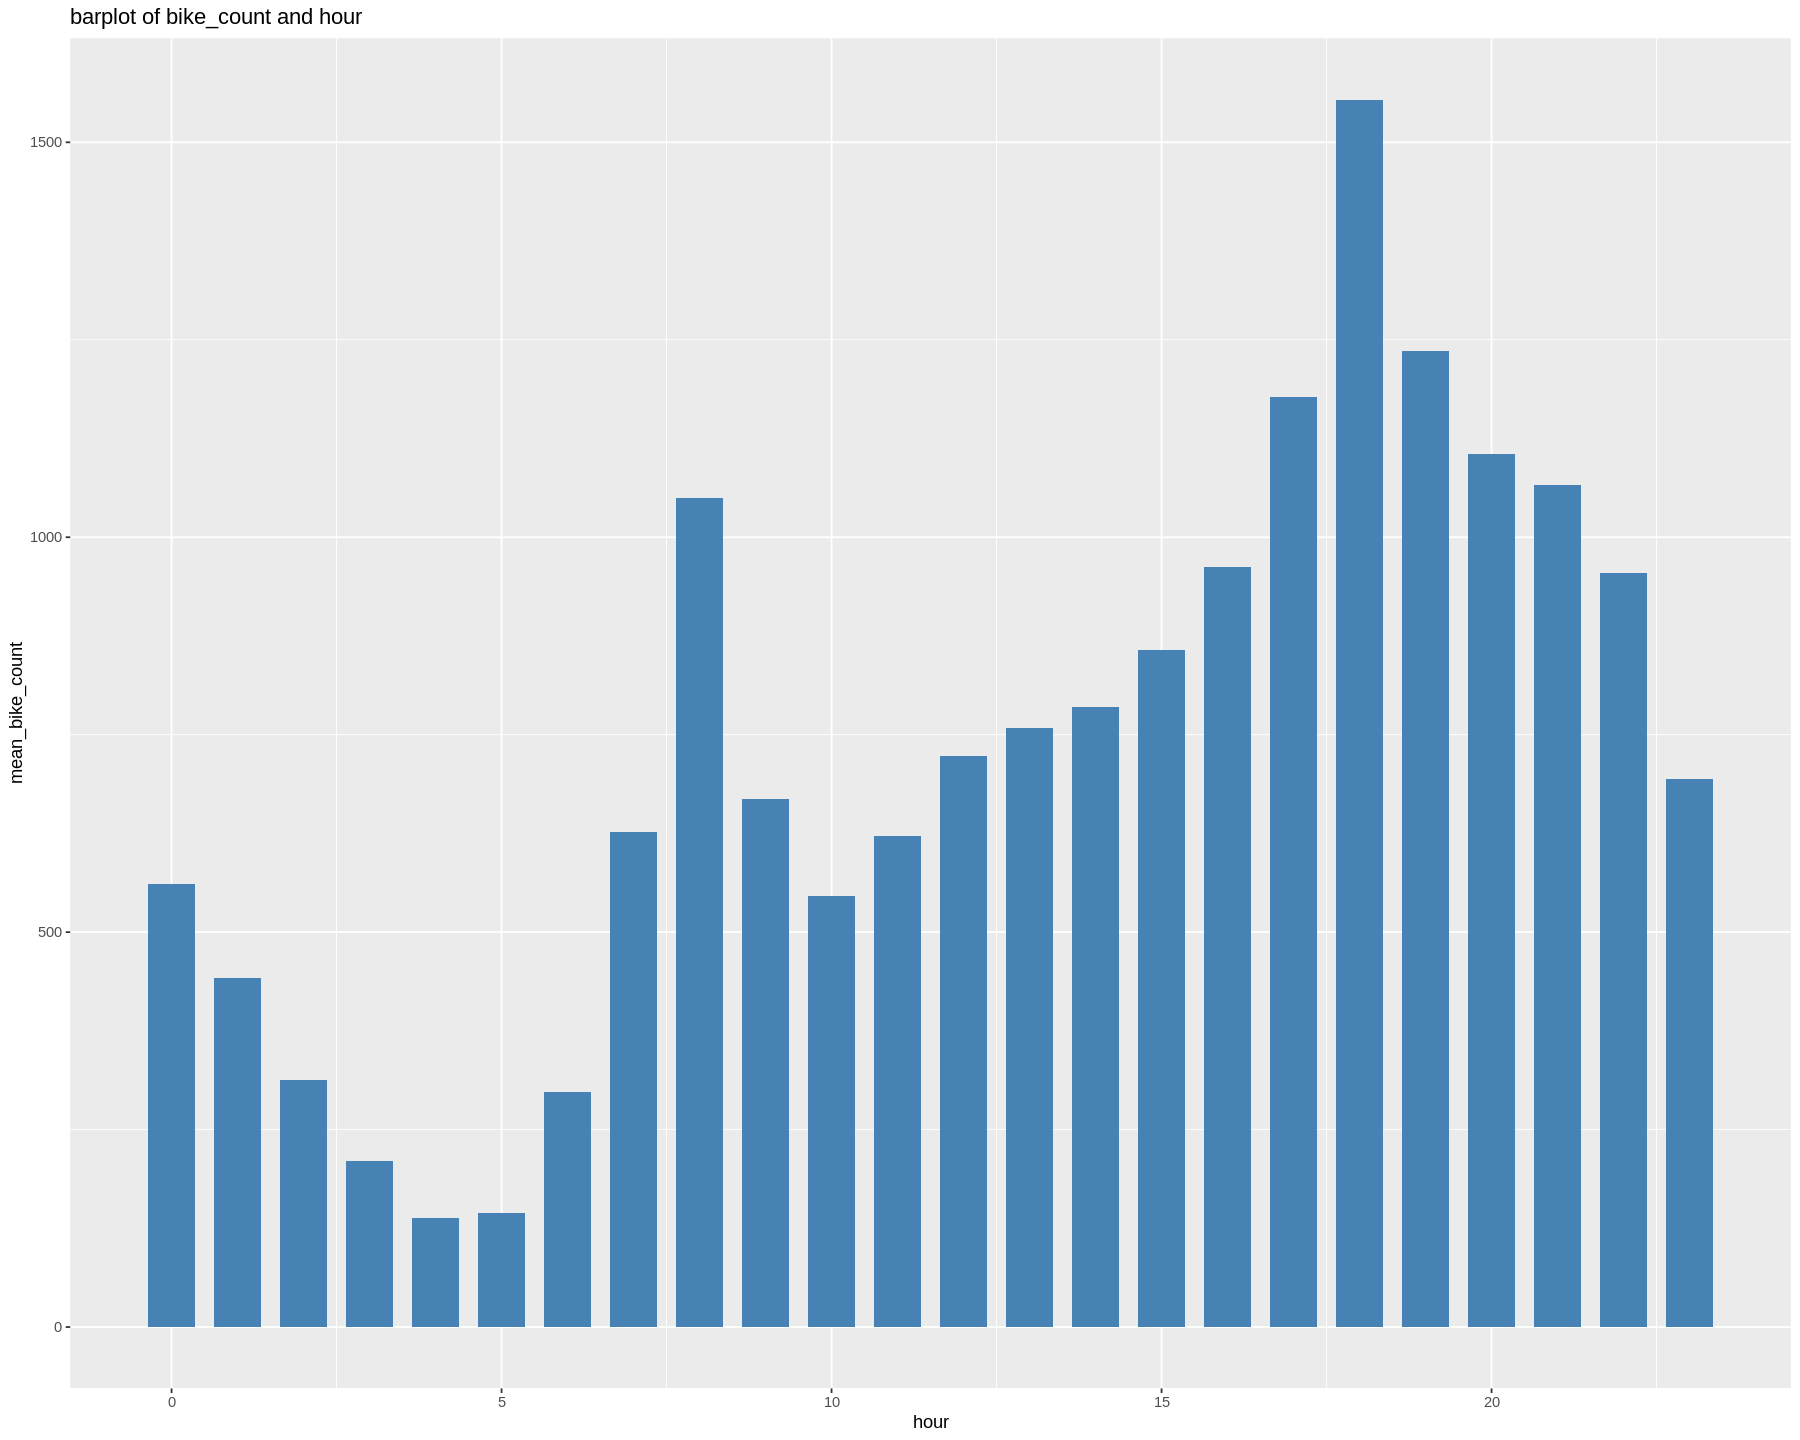

In [32]:
bike_data_1_plot <- bike_data_1 %>%
   ggplot(aes(x=hour, y= mean_bike_count)) +
   geom_bar(stat="identity",width=0.7, fill="steelblue")+  
   ggtitle("barplot of bike_count and hour")
bike_data_1_plot


In [33]:
bike_data_2 <- bike_data %>%
              select(- date)%>%
              group_by(temperature) %>%
              summarise(mean_bike_count= mean(bike_count))
bike_data_2

temperature,mean_bike_count
<dbl>,<dbl>
-17.8,322.0
-17.5,145.5
-17.4,64.0
⋮,⋮
39.0,1033
39.3,531
39.4,561


`geom_smooth()` using formula 'y ~ x'



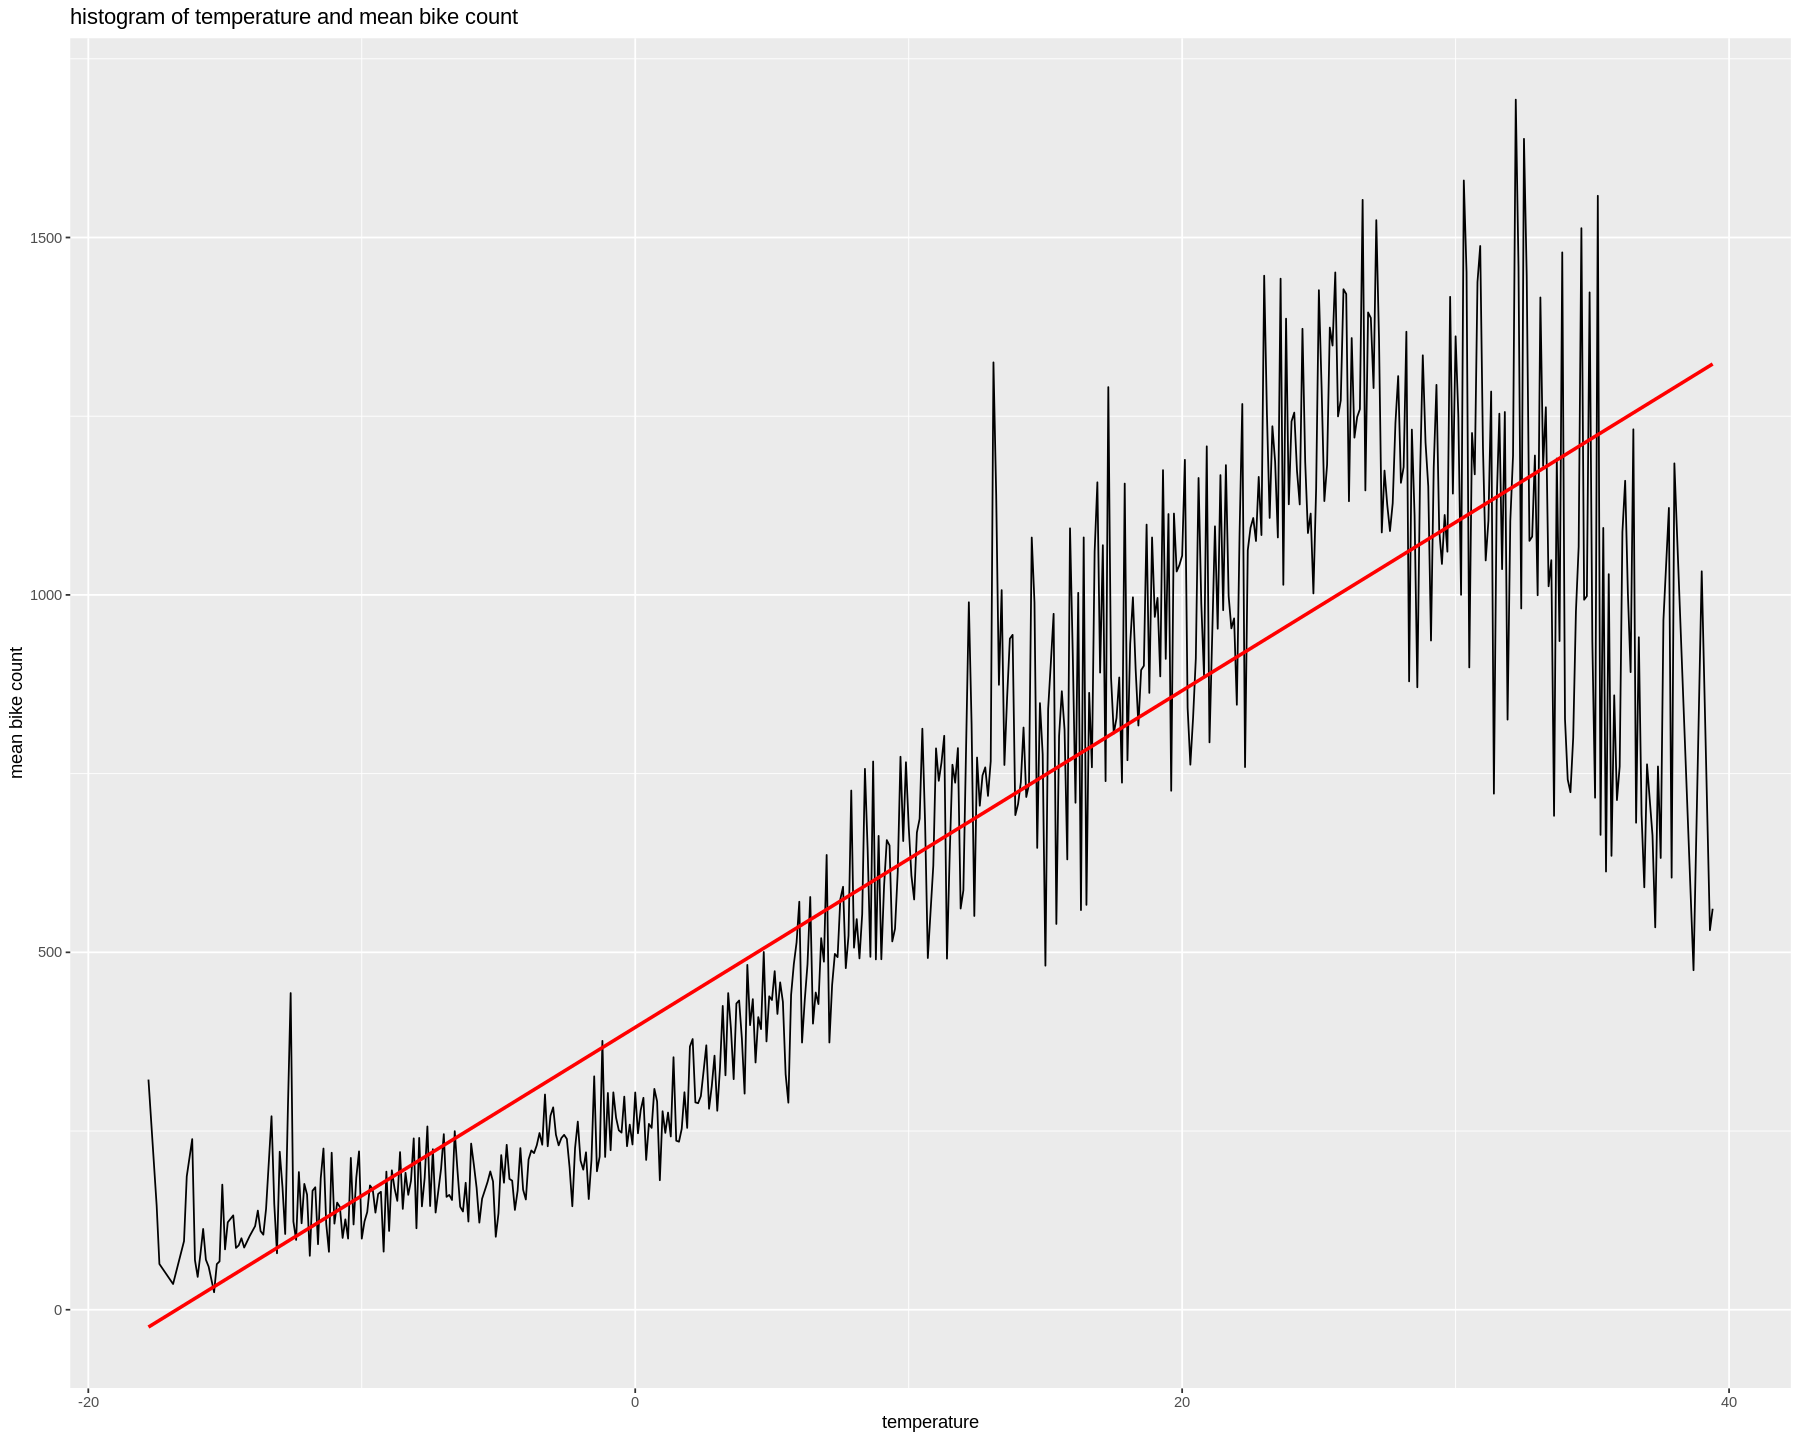

In [78]:
bike_plot_2 <- 
     ggplot(bike_data_2, aes(x=temperature,y=mean_bike_count))+
     geom_line()+
     geom_smooth(method=lm , color="red", se=FALSE) +
     labs(x ="temperature", y="mean bike count")+
     ggtitle("histogram of temperature and mean bike count")
 
bike_plot_2

`From the above two plots, we can see that the bike count
varies greatly with temperature and hour, as we can see from the correlation plot.`

### building predictive plot

## Methods: Plan

## References